In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import mutual_info_classif, f_classif, chi2
from scipy.stats import shapiro, kstest, chi2_contingency, f_oneway
import statistics
import tese_func
import heapq
import math
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import pickle
from matplotlib_venn import venn3_unweighted
from sklearn.datasets import load_breast_cancer
#sns.set_palette("pastel", desat=0.8)

leg_size=16
title_size=16
axis_size = 18
alpha=0.6
dpi = 300
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [2]:
data = pd.read_csv("data/data_ipet.csv")
clin = 766
target = "ipet2"

reps = {"I A": 1, "I B":2, "II A":3, "II B":4, "III A":5, "III B":6, "IV A":7, "IV B":8}
data["stage"] = data["stage"].replace(reps)
clinic = data.iloc[:,clin:]
gene = data.iloc[:,1:clin]
gene[target] = data[target]

palette = ["#4E89AE", "#43658B", "#ED6663", "#FFA372"]
print(data.shape)
data.head()

(103, 771)


,id,A2M,ABCB1,ABCF1,ABL1,ADA,ADORA2A,AGK,AICDA,AIRE,...,ZC3H14,ZKSCAN5,ZNF143,ZNF205,ZNF346,gender,age,stage,lmr>2.1,ipet2
0,GSM3860476,10.61,7.83,10.09,8.34,8.48,8.90,7.30,0.36,6.44,...,8.93,5.38,7.88,3.59,7.15,0,18,3,1,0
1,GSM3860477,11.14,11.88,1.70,10.60,10.58,11.45,10.90,1.70,11.42,...,10.27,8.77,1.70,1.70,10.75,1,51,3,1,0
2,GSM3860478,9.91,9.94,9.04,8.60,9.67,9.56,9.51,0.16,9.43,...,9.51,7.68,7.58,2.63,8.62,1,38,3,0,0
3,GSM3860479,11.89,8.56,9.99,8.47,9.54,8.61,8.10,1.35,6.68,...,9.69,6.36,8.91,1.35,8.25,0,50,8,0,0
4,GSM3860480,9.69,7.15,9.27,8.29,8.39,8.14,7.17,0.66,5.43,...,9.40,5.72,7.79,5.07,7.43,1,22,3,1,0


# MI + Wilk

In [3]:
volc = pd.read_csv("volcano.csv")
lfc_thr = 1
pv_thr = 0.05
volc.loc[volc["pvalue"] == 0, 'pvalue'] = 0.0001
diff_reg = volc[ (abs(volc["log2FoldChange"])>lfc_thr) & (volc["pvalue"]<pv_thr) ]

In [4]:
selgenes = ["CXCL2", "CXCL3", "CCL18", "TREM1", "SAA1", "PLAU", "FN1",
            "SPP1", "ITGA5", "CD9", "LRP1", "THBS1", "VEGFA"]
clinic_var = ["gender", "age","stage", "lmr>2.1", "ipet2"]

union, inter, pv_mi,pv_wi = tese_func.feat_select_miwi(threshold=0.05, prev_sel=selgenes)
print("-"*80)
union1, inter1, _, _ = tese_func.feat_select_miwi(threshold=0.1, prev_sel=selgenes)

#remover vars clinicas
union_g = [x for x in union if x not in clinic_var]
inter_g = [x for x in inter if x not in clinic_var]
print(len(union_g))
print(len(inter_g))
union1_g = [x for x in union1 if x not in clinic_var]
inter1_g = [x for x in inter1 if x not in clinic_var]
print("-"*80)
print("Intersection of FC and intersection MIWI05: ",list( set(diff_reg["gene_symbol"]) & set(inter_g) ))
print("Intersection of FC and union MIWI05: ", len(list( set(diff_reg["gene_symbol"]) & set(union_g) )))

Features mi with p-value <= 0.05: 97
Features wi with p-value <= 0.05: 99

Union of features from MI and Wilcoxon has len: 174 
Intersection of features from MI and Wilcoxon has len: 22 

Previously selected in union: ['THBS1', 'CD9', 'CXCL2', 'SAA1', 'VEGFA', 'ITGA5']
Previously selected in intersection: []
--------------------------------------------------------------------------------
Features mi with p-value <= 0.1: 155
Features wi with p-value <= 0.1: 132

Union of features from MI and Wilcoxon has len: 250 
Intersection of features from MI and Wilcoxon has len: 37 

Previously selected in union: ['CXCL3', 'THBS1', 'FN1', 'CD9', 'CXCL2', 'SAA1', 'LRP1', 'VEGFA', 'ITGA5']
Previously selected in intersection: []
172
21
--------------------------------------------------------------------------------
Intersection of FC and intersection MIWI05:  ['FCER2']
Intersection of FC and union MIWI05:  25


In [5]:
t = data.iloc[:,1:clin]
t = data[union1]
t.T.to_csv("~/Desktop/genesrf.csv", sep='\t')



## Intersection of methods

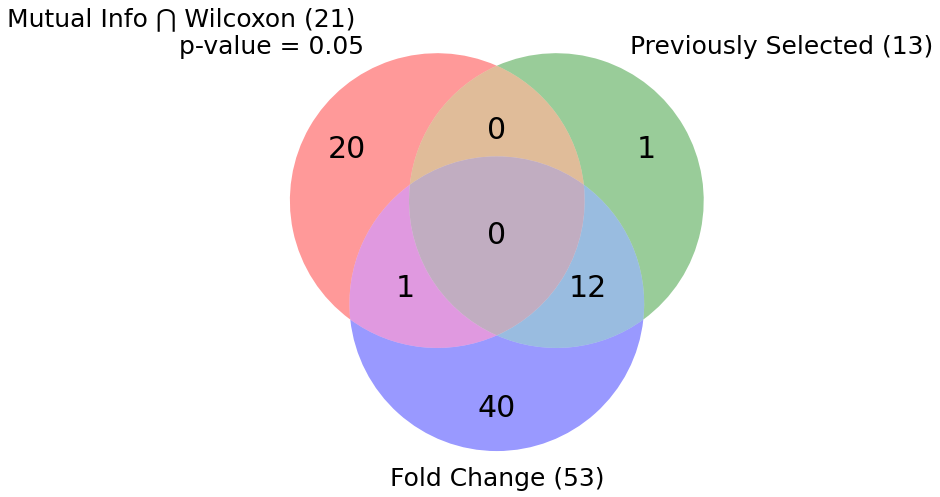

In [6]:
set1 = set(inter_g)
set2 = set(selgenes)
set3 = set(diff_reg["gene_symbol"])

fig, ax = plt.subplots(1,1,figsize=(12,12))
out = venn3_unweighted([set1, set2, set3], 
                       ('Mutual Info ⋂ Wilcoxon ({}) \n p-value = 0.05'.format(len(set1)), 
                        'Previously Selected ({})'.format(len(set2)), 
                        'Fold Change ({})'.format(len(set3)) ) )
for text in out.set_labels:
    text.set_fontsize(25)
for text in out.subset_labels:
    text.set_fontsize(30)

plt.tight_layout()
plt.savefig("./images/venn.png", dpi=dpi)
plt.show()

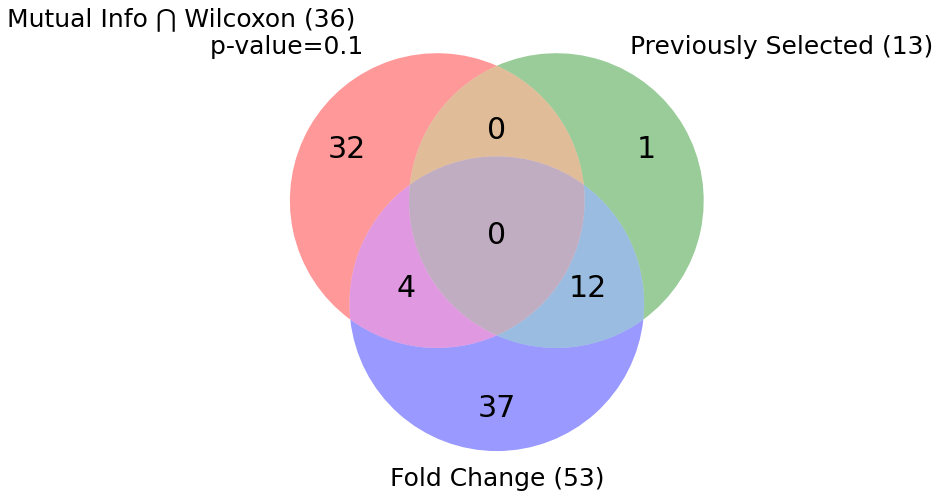

In [7]:
set1 = set(inter1_g)
set2 = set(selgenes)
set3 = set(diff_reg["gene_symbol"])

fig, ax = plt.subplots(1,1,figsize=(12,12))
out = venn3_unweighted([set1, set2, set3], 
                       ('Mutual Info ⋂ Wilcoxon ({}) \n p-value=0.1'.format(len(set1)), 
                        'Previously Selected ({})'.format(len(set2)), 
                        'Fold Change ({})'.format(len(set3)) ) )
for text in out.set_labels:
    text.set_fontsize(25)
for text in out.subset_labels:
    text.set_fontsize(30)

plt.tight_layout()
plt.savefig("./images/venn.png", dpi=dpi)
plt.show()

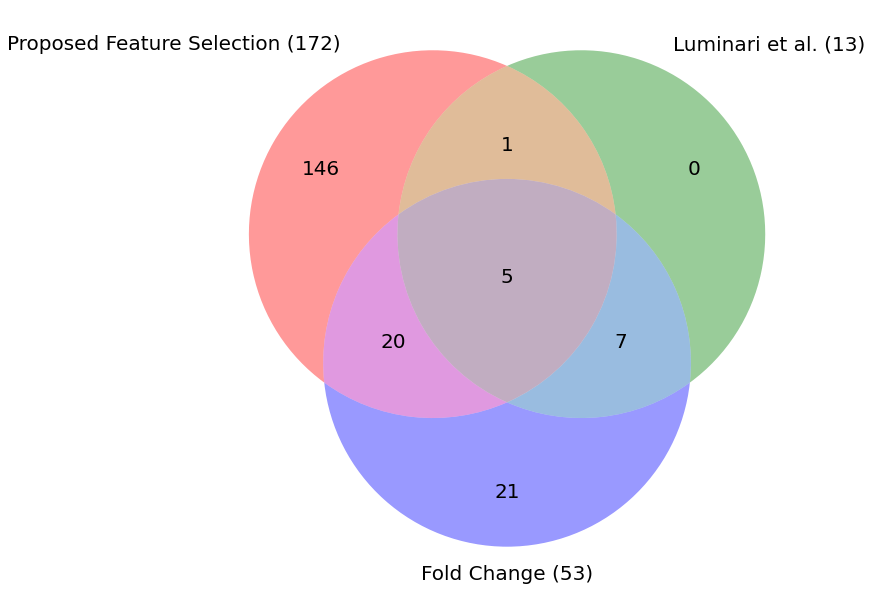

In [15]:
set1 = set(union_g)
set2 = set(selgenes)
set3 = set(diff_reg["gene_symbol"])

fig, ax = plt.subplots(1,1,figsize=(12,12), constrained_layout=True)
out = venn3_unweighted([set1, set2, set3], 
                       ('Proposed Feature Selection ({})'.format(len(set1)), 
                        'Luminari et al. ({})'.format(len(set2)), 
                        'Fold Change ({})'.format(len(set3)) ) )
for text in out.set_labels:
    text.set_fontsize(20)
for text in out.subset_labels:
    text.set_fontsize(20)

#plt.tight_layout()
plt.savefig("./images/venn.png", dpi=dpi)
plt.show()

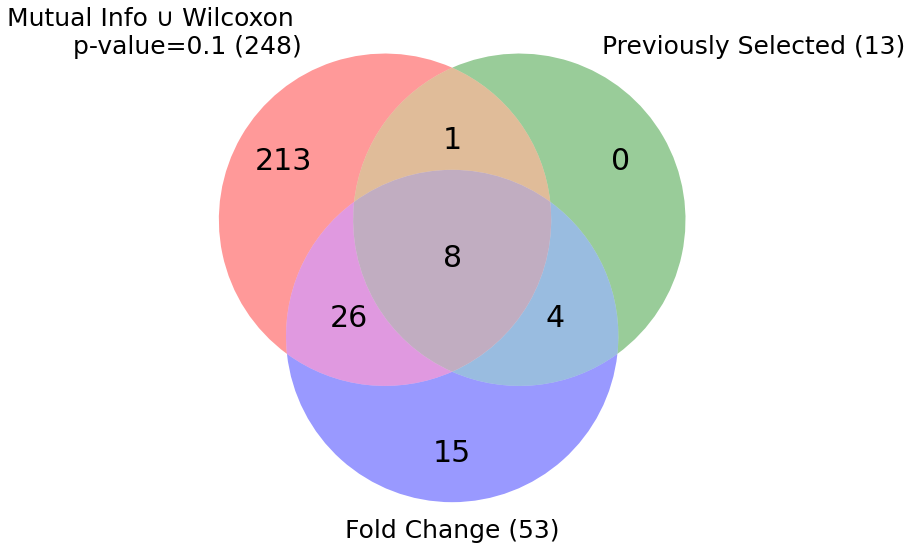

In [10]:
set1 = set(union1_g)
set2 = set(selgenes)
set3 = set(diff_reg["gene_symbol"])

fig, ax = plt.subplots(1,1,figsize=(12,12))
out = venn3_unweighted([set1, set2, set3], 
                       ('Mutual Info ∪ Wilcoxon \n p-value=0.1 ({})'.format(len(set1)), 
                        'Previously Selected ({})'.format(len(set2)), 
                        'Fold Change ({})'.format(len(set3)) ) )
for text in out.set_labels:
    text.set_fontsize(25)
for text in out.subset_labels:
    text.set_fontsize(30)

plt.tight_layout()
plt.savefig("./images/venn.png", dpi=dpi)
plt.show()

## Distribution of Mutual Info ⋂ Wilcoxon genes

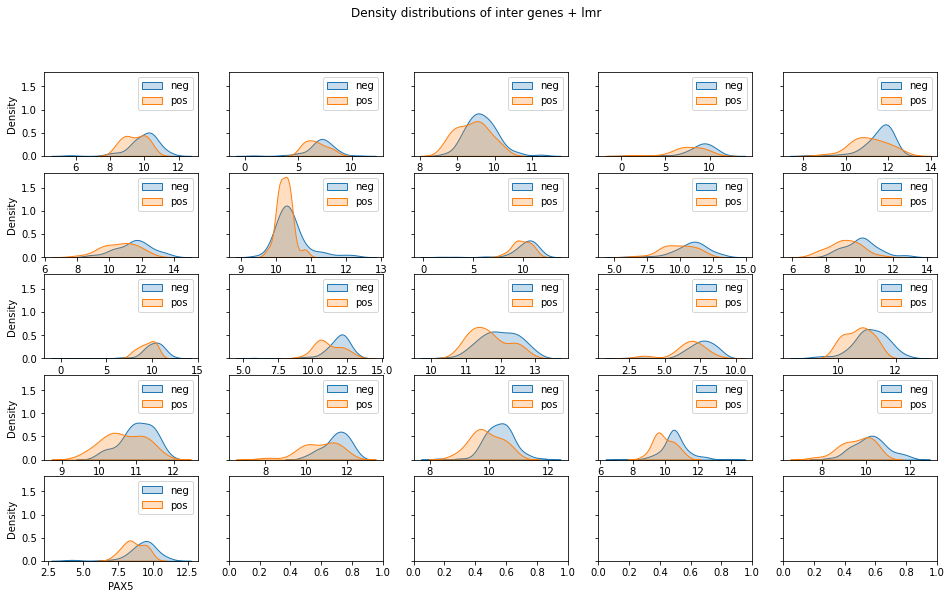

In [11]:
data0 = data[ data[target]==0]
data1 = data[ data[target]==1]

s = math.ceil(math.sqrt(len(inter_g)))
fig, axes = plt.subplots(s, s, figsize=(16, 9), sharey=True)
axes = axes.flatten()
fig.suptitle('Density distributions of inter genes + lmr')

for i,g in enumerate(inter_g):
    #sns.kdeplot(data=data, x=gene, hue=target,fill=True, ax=axes[i])
    #sns.histplot(data, x=gene, hue=target, stat="probability", ax=axes[i])
    sns.kdeplot(data0[g], ax=axes[i], fill=True)
    sns.kdeplot(data1[g], ax=axes[i], fill=True)
    axes[i].legend(("neg", "pos"), loc="best")

## Distribution of all intersect + target

In [12]:
#to_plot = inter + [target,]
#sns.pairplot(data[to_plot], hue=target)

## Boxplot of Mutual Info ⋂ Wilcoxon genes

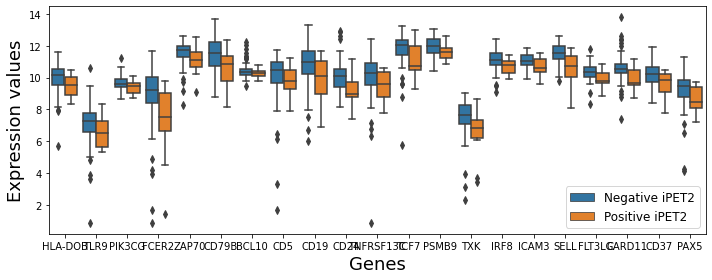

In [15]:
box = pd.DataFrame(columns=["values", "feature", "target"])

inter_gene = inter_g

for a in inter_gene:
    temp = pd.DataFrame()
    temp["values"] = data[a]
    temp["feature"] = a
    temp["target"] = data[target]
    box = box.append(temp)
    
box["target"] = box["target"].replace({0: "Negative iPET2", 1:"Positive iPET2"})

fig, ax = plt.subplots(1,1, figsize=(14,5))
sns.boxplot(x="feature", y="values", hue="target", data=box, ax=ax)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, fontsize=leg_size-4)

#ax.legend(("Negative iPET2", "Positive iPET2"), loc="best", fontsize=leg_size)
ax.set_xlabel("Genes", fontsize=axis_size)
ax.set_ylabel("Expression values", fontsize=axis_size)
#ax.set_title("Boxplot of conditioned distributions", fontsize=title_size)

plt.tight_layout()
plt.savefig("./images/boxplot.png", dpi=dpi)
plt.show()

(-1.5, 0.25)

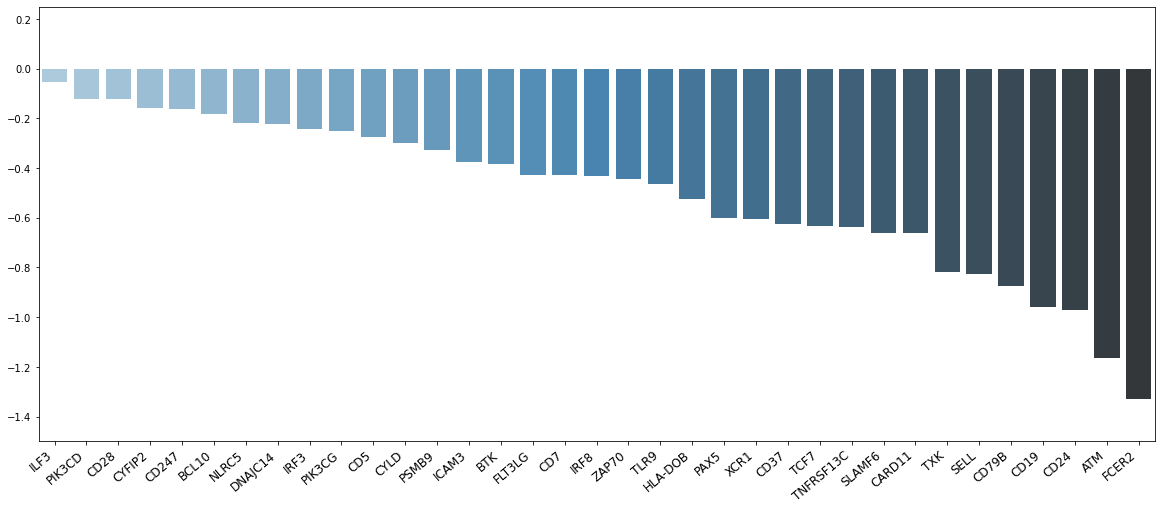

In [21]:
fc_genes = tese_func.logfc_select(gene, target, None)[inter_gene]
fc_genes = fc_genes.reindex(fc_genes.abs().sort_values().index) #order by absolute

fig, ax = plt.subplots(1,1, figsize=(20,8))
ax = sns.barplot(data=pd.DataFrame(fc_genes).T,  palette="Blues_d")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=40, ha="right")
ax.set_ylim(-1.5,0.25)

## Fold Changes of Mutual Info ∪ Wilcoxon 0.05

(-1.5, 2.5)

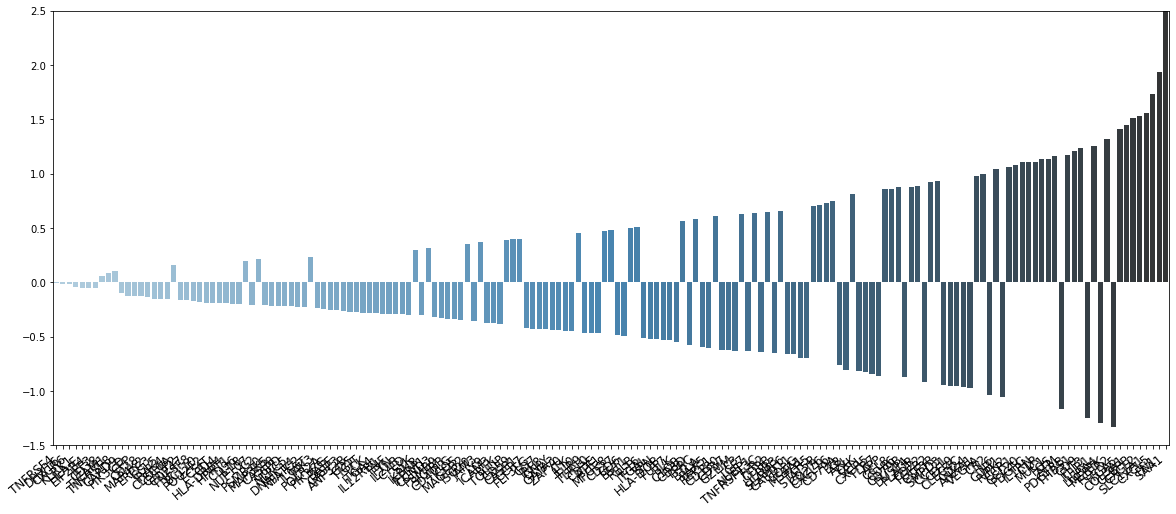

In [25]:
fc_genes = tese_func.logfc_select(gene, target, None)[union_g]
fc_genes = fc_genes.reindex(fc_genes.abs().sort_values().index) #order by absolute

fig, ax = plt.subplots(1,1, figsize=(20,8))
ax = sns.barplot(data=pd.DataFrame(fc_genes).T,  palette="Blues_d")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=40, ha="right")
ax.set_ylim(-1.5,2.5)

## Fold Changes of Mutual Info ∪ Wilcoxon 0.1

(-1.5, 2.5)

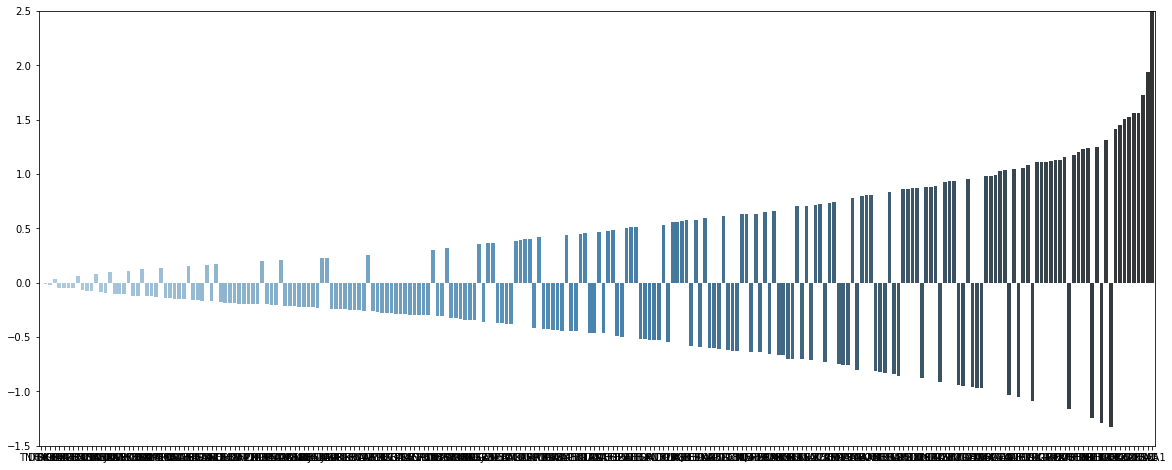

In [24]:
fc_genes = tese_func.logfc_select(gene, target, None)[union1_g]
fc_genes = fc_genes.reindex(fc_genes.abs().sort_values().index) #order by absolute

fig, ax = plt.subplots(1,1, figsize=(20,8))
sns.barplot(data=pd.DataFrame(fc_genes).T,  palette="Blues_d")
ax.set_ylim(-1.5,2.5)

## Hierarchical Clustering
### Intersection of MIWI

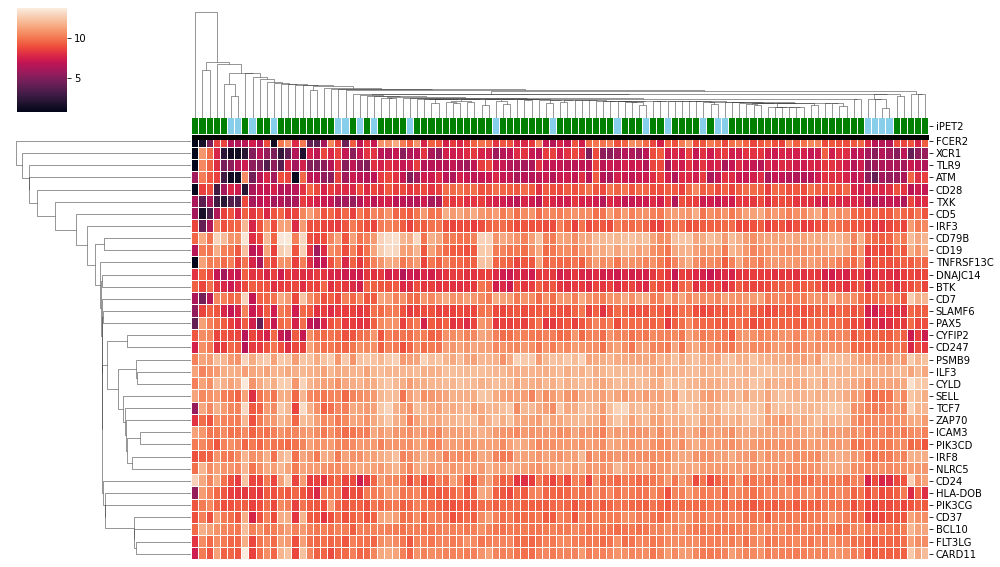

In [29]:
df1 = data[inter1].drop(columns=["lmr>2.1"])
df1 = df1.rename(columns={target: "iPET2"})
data = data.rename(columns={target: "iPET2"})

color_dict=dict(zip(np.unique(data["iPET2"]),np.array(['g','skyblue'])))
row_colors = data["iPET2"].map(color_dict)


m ="single"
cluster = sns.clustermap(df1.T, method=m, col_colors=row_colors, yticklabels=True, 
                         xticklabels=False, figsize=(14,8), linewidths=0.01)
#cluster.ax_heatmap.axvline(1, color='b', lw=2)
cluster.ax_heatmap.axhline(0, color='black', lw=10)
cluster

data = data.rename(columns={"iPET2": target})

#plt.tight_layout()
plt.savefig("./images/cluster.png", dpi=dpi)

### Union of MIWI

/home/andre/anaconda3/envs/tese/lib/python3.8/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


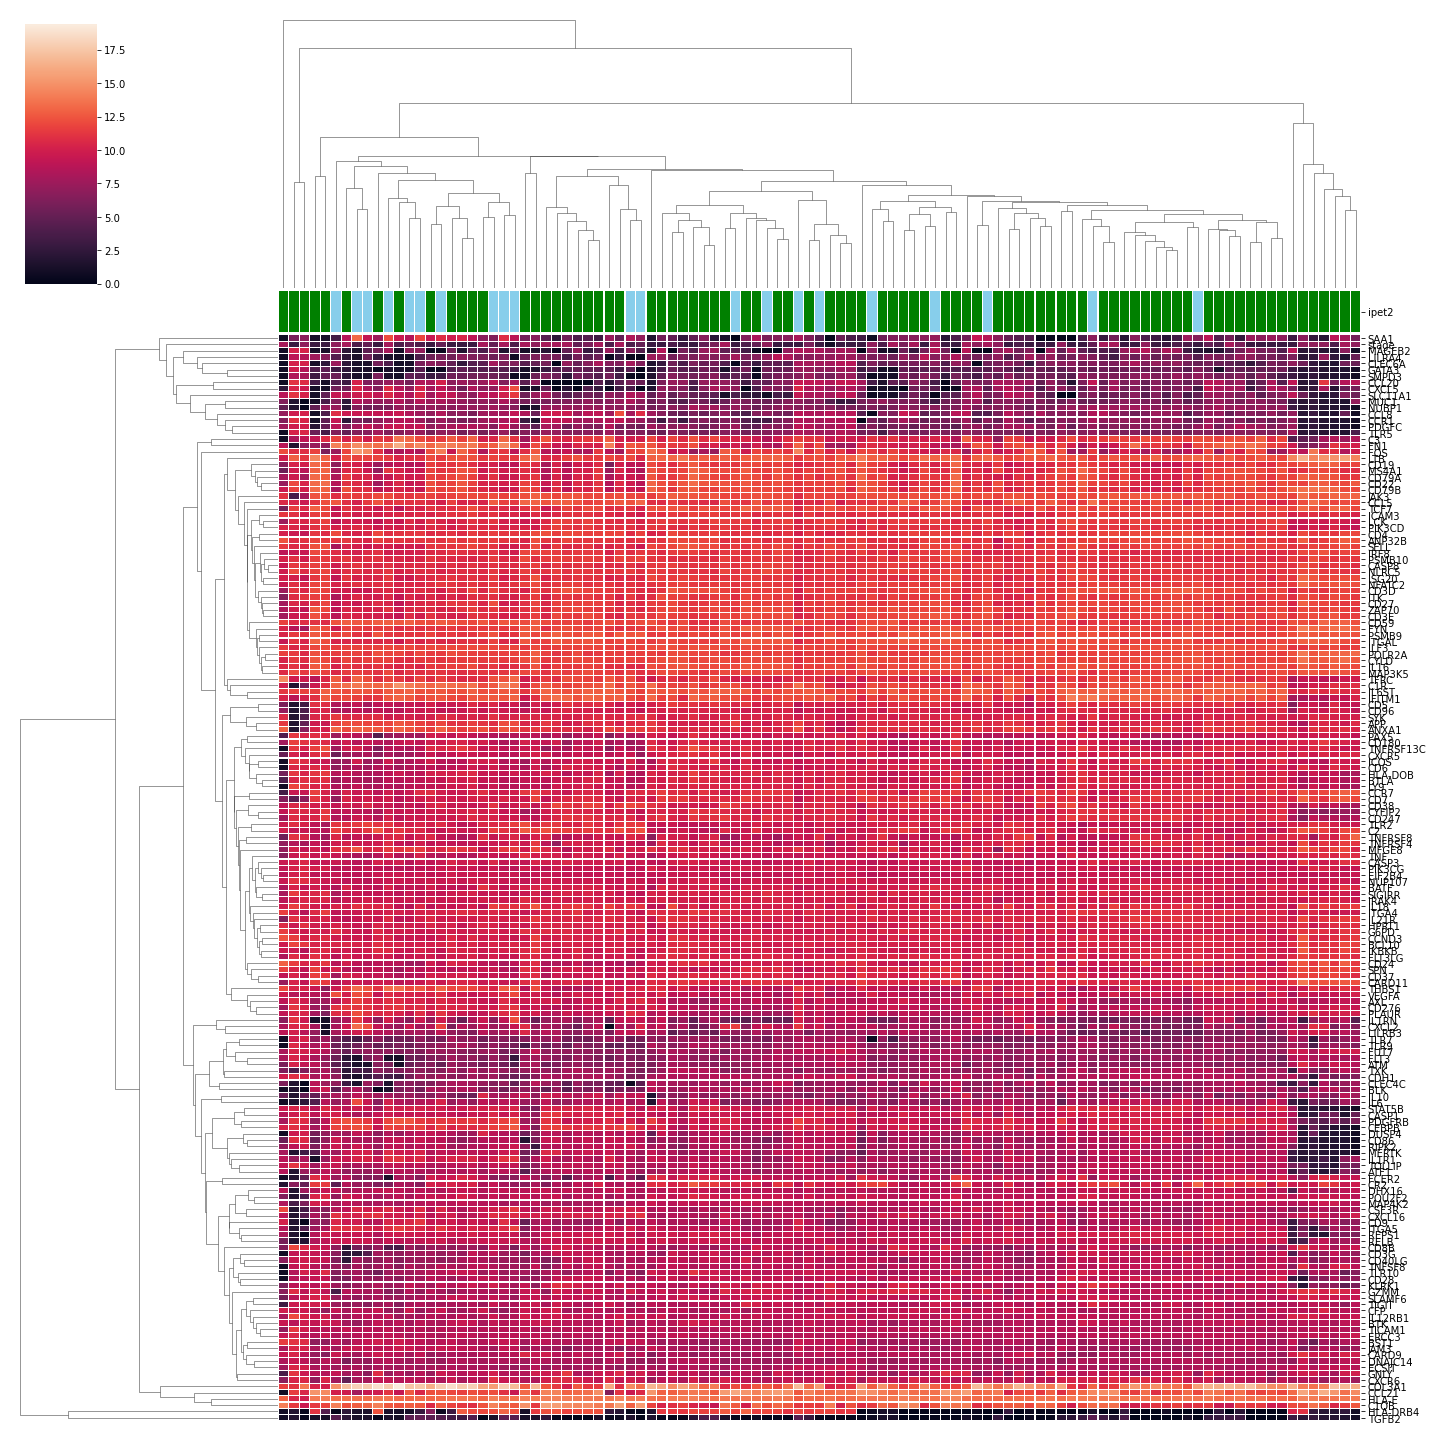

In [27]:
df = data[union].drop(columns=["lmr>2.1"])
color_dict=dict(zip(np.unique(data[target]),np.array(['g','skyblue'])))
row_colors = data[target].map(color_dict)

sns.clustermap(df.T, method="average", col_colors=row_colors, yticklabels=True, xticklabels=False, 
               figsize=(20,20), linewidths=0.1)

### Union of MIWI 0.1

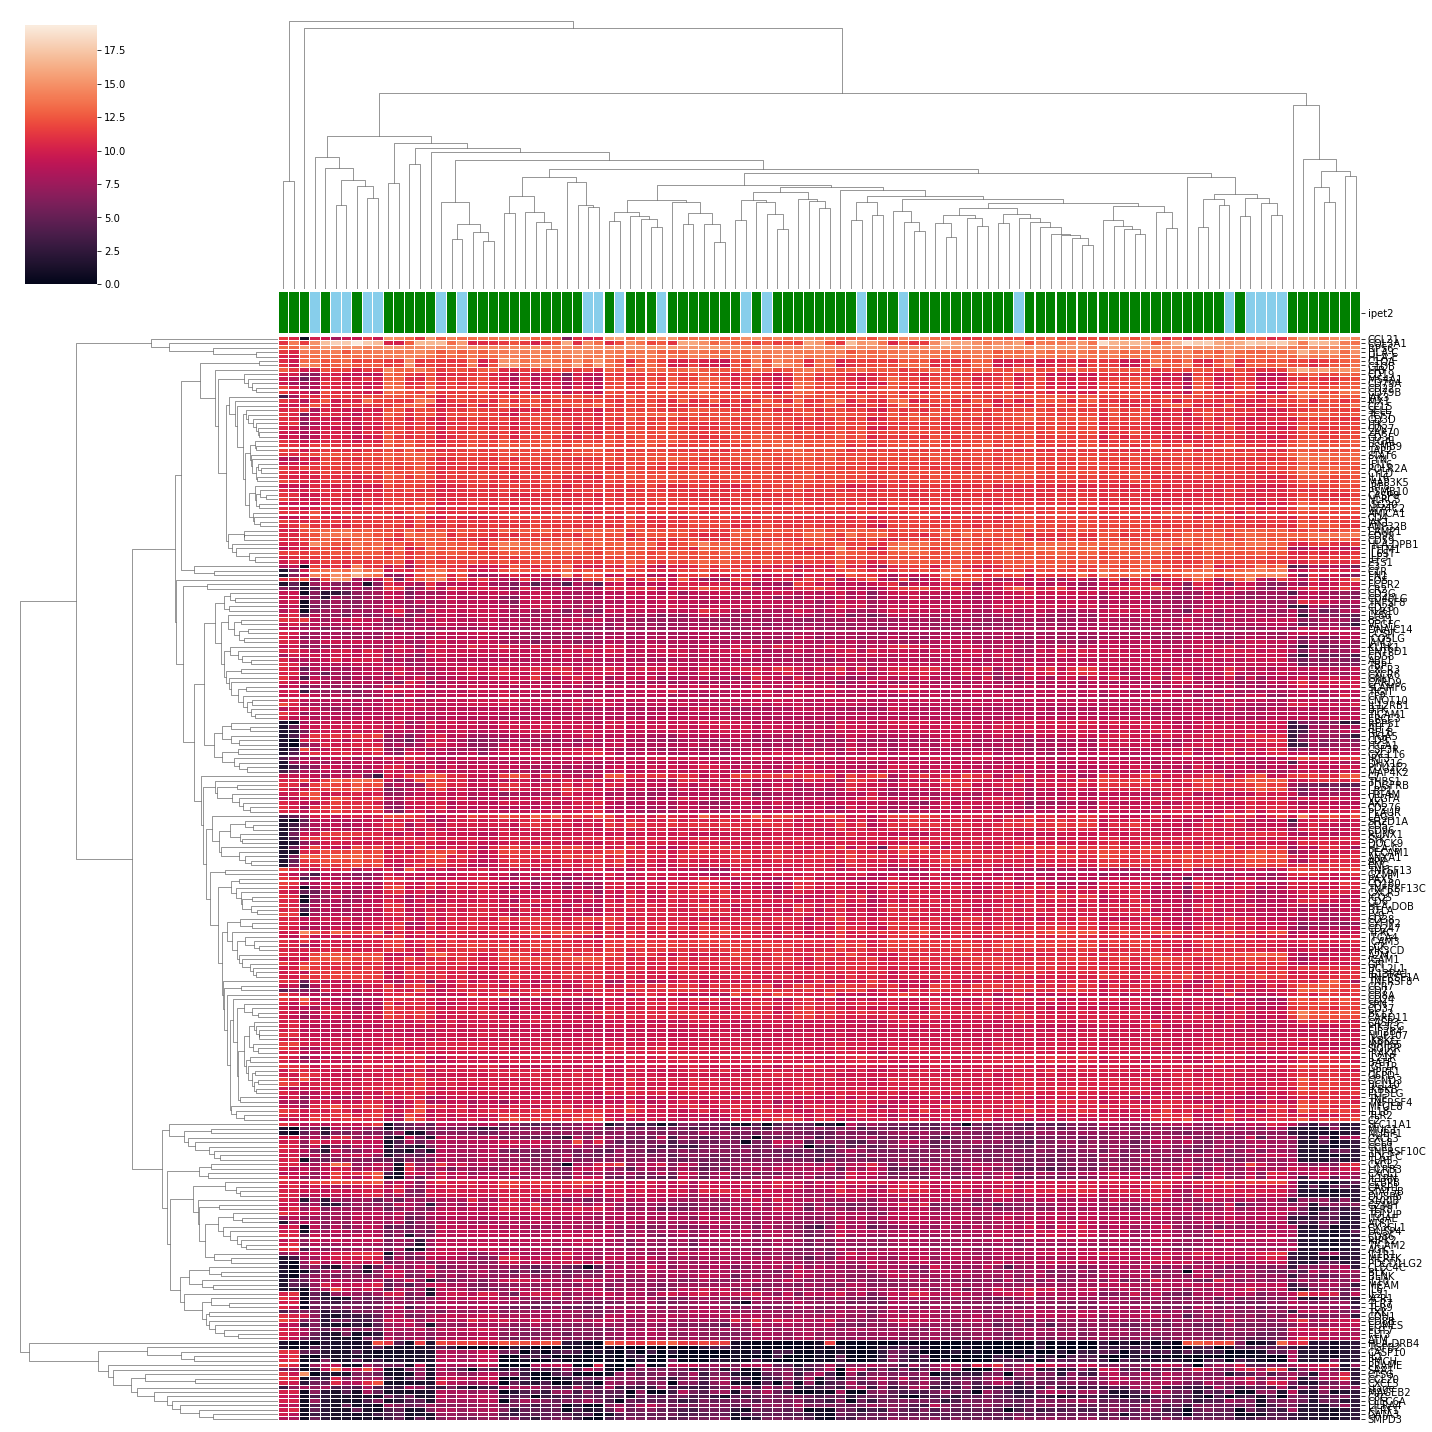

In [28]:
df = data[union1].drop(columns=["lmr>2.1"])
color_dict=dict(zip(np.unique(data[target]),np.array(['g','skyblue'])))
row_colors = data[target].map(color_dict)

sns.clustermap(df.T, method="average", col_colors=row_colors, yticklabels=True, xticklabels=False, 
               figsize=(20,20), linewidths=0.1)

## PCA

<ipython-input-5-4ce7751dea80>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_values)


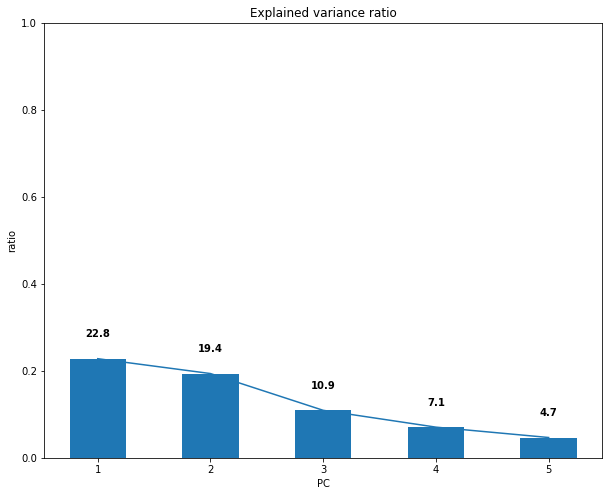

In [5]:
y = gene[target]

X = gene.drop(columns=[target])

# In general, it's a good idea to scale the data prior to PCA.
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)    
pca = PCA()
x_new = pca.fit_transform(X)
PC = pca.components_
var = pca.explained_variance_

t=5
# PLOT EXPLAINED VARIANCE RATIO
fig = plt.figure(figsize=(10, 8))
plt.title('Explained variance ratio')
plt.xlabel('PC')
plt.ylabel('ratio')
x_values = [str(i) for i in range(1, len(pca.components_[:t]) + 1)]
bwidth = 0.5
ax = plt.gca()
ax.set_xticklabels(x_values)
ax.set_ylim(0.0, 1.0)
ax.bar(x_values, pca.explained_variance_ratio_[:t], width=bwidth)
ax.plot(pca.explained_variance_ratio_[:t])
for i, v in enumerate(pca.explained_variance_ratio_[:t]):
    ax.text(i, v+0.05, f'{v*100:.1f}', ha='center', fontweight='bold')
plt.show()

[277, 740, 720, 243, 136, 762, 109, 142, 146, 565]


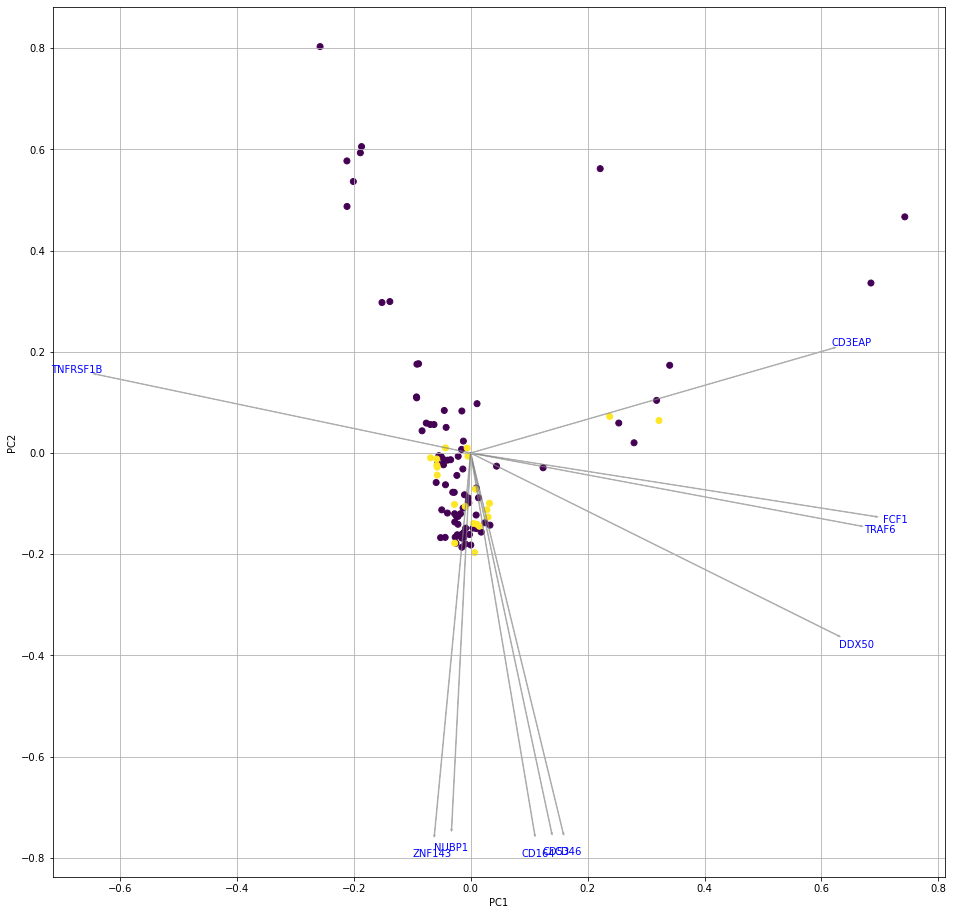

In [6]:
def myplot(score,coeff,labels=None):
    inc = 10
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    fig,ax = plt.subplots(figsize=(16,16))
    plt.scatter(xs * scalex,ys * scaley, c = y)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0]*inc, coeff[i,1]*inc,color = 'grey',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.05*inc, coeff[i,1] * 1.05*inc, "Var"+str(i+1), color = 'b', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.05*inc, coeff[i,1] * 1.05*inc, labels[i], color = 'b', ha = 'center', va = 'center')
    #plt.xlim(-1,1)
    #plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

#Call the function. Use only the 2 PCs.
#myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]))
#plt.show()
#print(X.shape)
n = 5
comps = np.transpose(pca.components_[0:2, :])
comps = pd.DataFrame(comps, columns=["C1","C2"])
comps1 = abs(comps).sort_values("C1",ascending=False).iloc[:n,:]
comps2 = abs(comps).sort_values("C2",ascending=False).iloc[:n,:]

indexes = comps1.append(comps2).index.tolist()
print(indexes)
coeff = comps.iloc[indexes].values
labels = gene.iloc[:,indexes].columns.tolist()      # TODO: CHECK IF RIGHT

myplot(x_new[:,0:2],coeff, labels)
plt.show()

## Generation of example ROC curves

<ipython-input-1-724452c87187>:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal', 'datalim')


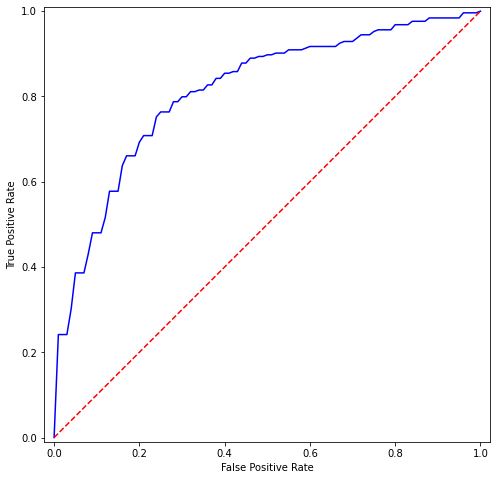

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import interp

from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve

X, y = make_classification(n_samples=500, random_state=100, flip_y=0.3)

cv = StratifiedKFold(n_splits=10)
tprs = []
base_fpr = np.linspace(0, 1, 101)

plt.figure(figsize=(8, 8))

for i, (train, test) in enumerate(cv.split(X, y)):
    model = LogisticRegression().fit(X[train], y[train])
    y_score = model.predict_proba(X[test])
    fpr, tpr, _ = roc_curve(y[test], y_score[:, 1])

    #plt.plot(fpr, tpr, 'b', alpha=0.15)
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
#std = tprs.std(axis=0)

#tprs_upper = np.minimum(mean_tprs + std, 1)
#tprs_lower = mean_tprs - std


plt.plot(base_fpr, mean_tprs, 'b')
#plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.show()

[2.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 9.96413597e-001 9.63845529e-001
 6.70296515e-001 3.46918617e-001 7.86917987e-002 1.31579633e-002
 1.66521020e-006 1.02176621e-010 3.99974566e-011 8.49300652e-015
 1.03174048e-015 1.46084857e-017 1.25936075e-018 5.50490347e-020
 2.84877964e-020 4.02048206e-042 2.82239135e-048 2.27457558e-055
 4.92617475e-062 7.45990742e-101 8.03512088e-107 6.45701420e-130
 4.21991151e-138 1.62569391e-242]


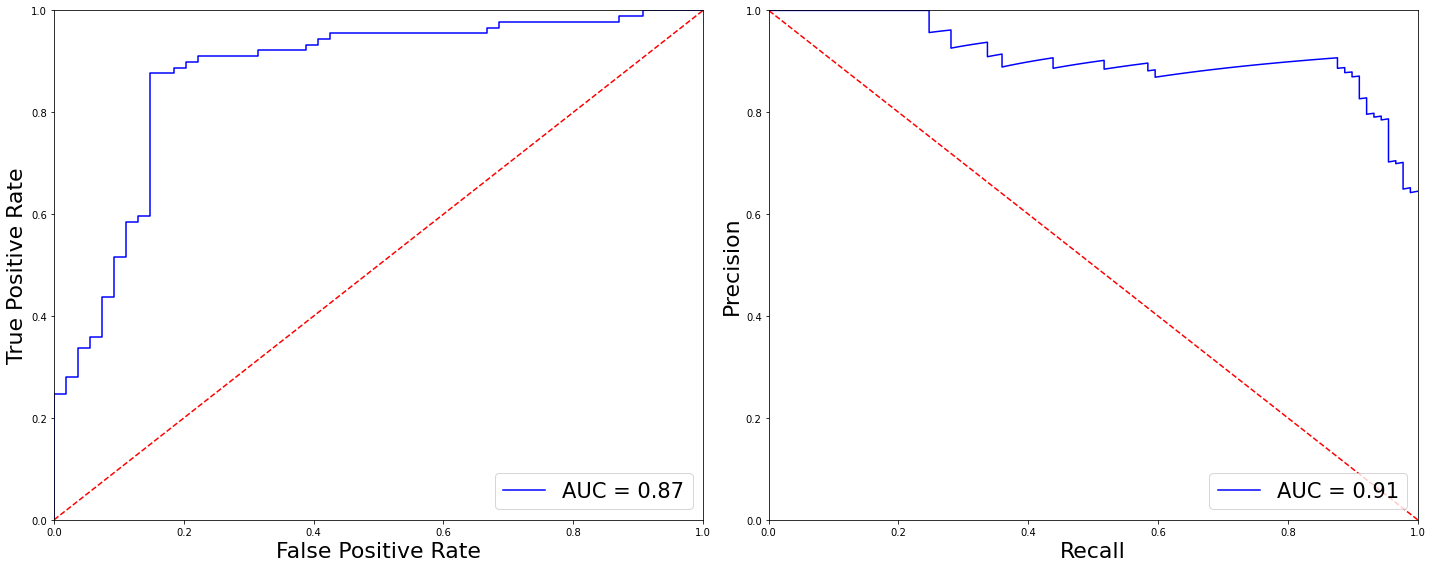

In [4]:
from sklearn.datasets import load_breast_cancer
from sklearn import metrics

X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)
np.random.shuffle(y_test[0:30])


model = GaussianNB()
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
print(threshold)

precision, recall, threshold2 = metrics.precision_recall_curve(y_test,preds)

roc_auc = metrics.auc(fpr, tpr)
pr_auc = metrics.auc(recall,precision)


# method I: plt
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2,figsize=(20,8))

#axs[0].set_title('Receiver Operating Characteristic Curve', fontsize=title_size)
axs[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
axs[0].legend(loc = 'lower right', fontsize=leg_size+5)
axs[0].plot([0, 1], [0, 1],'r--')
axs[0].set_xlim([0, 1])
axs[0].set_ylim([0, 1])
axs[0].set_ylabel('True Positive Rate', fontsize=axis_size+4)
axs[0].set_xlabel('False Positive Rate', fontsize=axis_size+4)

#axs[1].set_title('Precision Recall Curve', fontsize=title_size)
axs[1].plot(recall, precision, 'b', label = 'AUC = %0.2f' % pr_auc)
axs[1].legend(loc = 'lower right', fontsize=leg_size+5)
axs[1].plot([1, 0], [0, 1],'r--')
axs[1].set_xlim([0, 1])
axs[1].set_ylim([0, 1])
axs[1].set_ylabel('Precision', fontsize=axis_size+4)
axs[1].set_xlabel('Recall', fontsize=axis_size+4)

plt.tight_layout()
plt.savefig("./images/roc.png", dpi=dpi)

plt.show()


In [10]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import interp

from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve

X, y = make_classification(n_samples=500, random_state=100, flip_y=0.3)

cv = StratifiedKFold(n_splits=10)
tprs = []
fprs = []
base_fpr = np.linspace(0, 1, 101)

plt.figure(figsize=(8, 8))

for i, (train, test) in enumerate(cv.split(X, y)):
    model = LogisticRegression().fit(X[train], y[train])
    y_score = model.predict_proba(X[test])
    print(y_score.shape)
    fpr, tpr, _ = roc_curve(y[test], y_score[:, 1])

    #plt.plot(fpr, tpr, 'b', alpha=0.15)
    #tpr = interp(base_fpr, fpr, tpr)
    #tpr[0] = 0.0
    tprs.append(tpr)
    fprs.append(fpr)

tprs = np.array(tprs)
fprs = np.array(fprs)

for i in tprs:
    print(i.shape)
mean_tprs = tprs.mean(axis=0)
mean_fprs = fprs.mean(axis=0)

#std = tprs.std(axis=0)

#tprs_upper = np.minimum(mean_tprs + std, 1)
#tprs_lower = mean_tprs - std


plt.plot(mean_fprs, mean_tprs, 'b')
#plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.show()

(50, 2)
(50, 2)
(50, 2)
(50, 2)
(50, 2)
(50, 2)
(50, 2)
(50, 2)
(50, 2)
(50, 2)
(19,)
(24,)
(24,)
(19,)
(18,)
(18,)
(13,)
(26,)
(22,)
(22,)


<ipython-input-10-673da2c74ee0>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tprs = np.array(tprs)
<ipython-input-10-673da2c74ee0>:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fprs = np.array(fprs)


ValueError: operands could not be broadcast together with shapes (19,) (24,) 

<Figure size 576x576 with 0 Axes>